# Séries temporais com Regressão Linear

**Autor**: [Maykon Schots](https://www.linkedin.com/in/maykon-schots/)

**Participação especial**: [Rafael Barbosa](https://www.linkedin.com/in/rafael-barbosa0/)

**Objetivo**: Temos uma série temporal de frequência diária de vendas que inicia em Jan/2020 e termina no final de Jul/2020. Queremos prever estas vendas para a próxima semana, dada as características que estão presentes no banco de dados abaixo. 

## 1. Bibliotecas e configurações adicionais

In [1]:
#--- Bibliotecas iniciais

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import holidays


#--- Configurações adicionais

plt.style.use("seaborn-muted")
pd.set_option("display.max_columns", None)

In [2]:
dados = pd.read_csv("data/output-dados-case.csv")
dados["Lead Created At"] = pd.to_datetime(dados["Lead Created At"], format = "%Y-%m-%d")

dados.head()

,Lead Created At,Lead Id,Purchase Source,JID,tempo_jornada,flag_jornada,flag_venda,Canal
0,2020-01-06 22:39:00,MSS-00003108-bf9d-4679-8780-36931ab4ae49-2020,fb-geral-lookalike-dco,1,1.0,Primeiro Contato,0.0,FB
1,2020-02-21 19:18:00,MSS-00003108-bf9d-4679-8780-36931ab4ae49-2020,sms-pre-carnaval-abandono,2,47.0,Ultimo Contato,0.0,SMS
2,2020-05-13 14:15:00,MSS-000031d0-5499-4e58-a88d-9afbcbb8ee9a-2019,yt-rmkt-videos-videovendas3,3,143.0,Ultimo Contato,0.0,YT
3,2020-07-23 22:28:00,MSS-00003bb2-b409-47b3-862f-e6c82b311d0c-2020,insta-bio,1,1.0,Primeiro Contato,0.0,FB
4,2020-05-12 22:51:00,MSS-0000610b-1170-47f5-990b-239d6eaef81b-2020,fb-rmkt-video-dco,1,1.0,Primeiro Contato,0.0,FB


---

- Observando o banco de dados, temos a informação de todas as interações em que o cliente teve com a loja

- A variável **flag_venda** indica se esta determinada interação cliente-loja resultou em uma compra ou não

- Então, o caminho para criar a nossa série temporal de vendas é:

    - Criar uma nova variável que sempre vai ter o valor de 1, indicando a interação quantitativamente
    
    - Filtrar somente as observações em que houveram venda
    
    - Com isso, faremos uma agregação da soma de todas as vendas por dia
    
---

In [3]:
dados["indicador_leads"] = 1

vol_diarios_compras = dados[dados["flag_venda"] == 1].resample("D", on = "Lead Created At")["indicador_leads"].sum()
vol_diarios_compras.head()

Lead Created At
2020-01-01    47
2020-01-02    70
2020-01-03    48
2020-01-04    81
2020-01-05    73
Freq: D, Name: indicador_leads, dtype: int64

## 2. Visualização da série temporal

- A série possui uma tendência de queda desde o início do ano

- Por determinado motivo, teve um pico no início de Julho

- Entretanto, mesmo com o pico de Julho, a série voltou ao padrão normal de queda

---

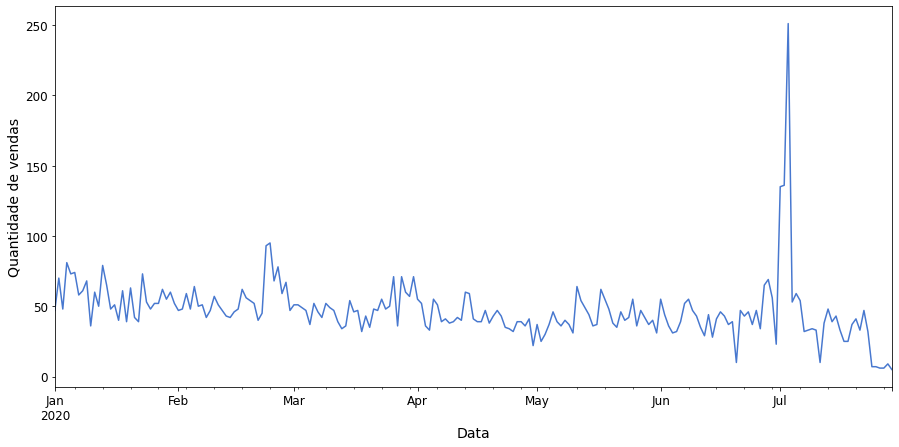

In [4]:
_ = plt.figure(figsize = [15, 7])
_ = vol_diarios_compras.plot(kind = "line")
_ = plt.xlabel("Data", fontsize = 14, color = "black")
_ = plt.ylabel("Quantidade de vendas", fontsize = 14, color = "black")
_ = plt.tick_params(axis = "x", labelsize = 12, labelcolor = "black")
_ = plt.tick_params(axis = "y", labelsize = 12, labelcolor = "black")

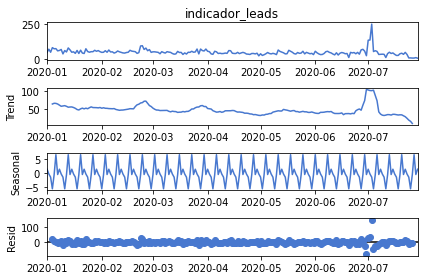

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(vol_diarios_compras, model = "additive")
result.plot()
plt.show()

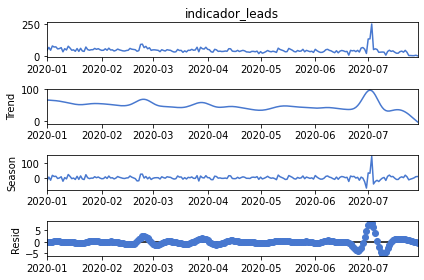

In [6]:
from statsmodels.tsa.seasonal import STL

stl = STL(vol_diarios_compras, seasonal = 3)
res = stl.fit()
fig = res.plot()

## 3. Variáveis e pré-processamento para a modelagem

- Abaixo podemos ver algumas *features* explicativas para melhorar o poder preditivo do modelo

### 3.1. Variável resposta: Quantidade de compras por mês 

- Como os *outliers* dessa série são visivelmente claros e específicos (início de Julho), então todos os valores de vendas acima de 100 serão considerados *outliers*

- Uma estratégia inicial, será considerar eles como nulos e utilizar diferentes estratégias de imputação para qual se adequa melhor. Entretanto, devido a limitação daquilo que está entre a cadeira e o computador, não houve como finalizar esta estratégia

- A estratégia será então utilizar uma interpolação linear

In [7]:
dados1 = pd.DataFrame(vol_diarios_compras).reset_index()

dados1["indicador_leads"] = dados1["indicador_leads"]*1.0
dados1["indicador_leads"] = dados1["indicador_leads"].apply(lambda x: np.nan if x >= 100 else x)

dados1.head()

,Lead Created At,indicador_leads
0,2020-01-01,47.0
1,2020-01-02,70.0
2,2020-01-03,48.0
3,2020-01-04,81.0
4,2020-01-05,73.0


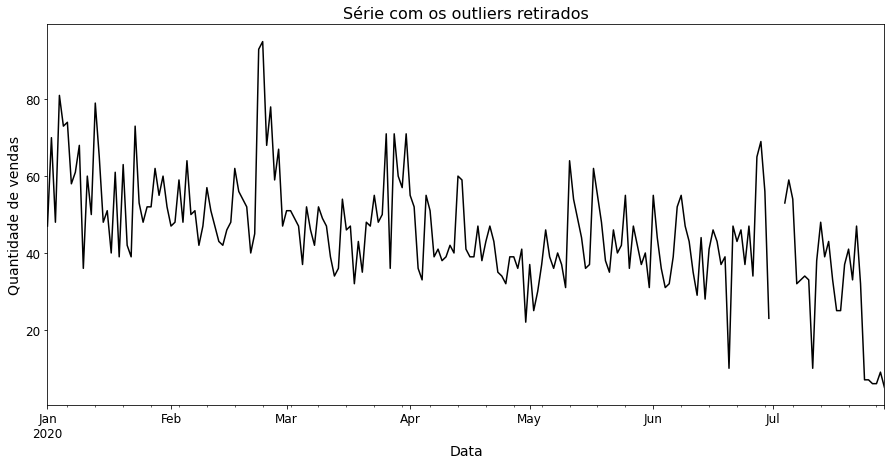

In [8]:
_ = dados1.plot(x = "Lead Created At", y = "indicador_leads", kind = "line", figsize = (15, 7), legend = False, color = "black")
_ = plt.title("Série com os outliers retirados", fontsize = 16, color = "black")
_ = plt.xlabel("Data", fontsize = 14, color = "black")
_ = plt.ylabel("Quantidade de vendas", fontsize = 14, color = "black")
_ = plt.tick_params(axis = "x", labelsize = 12, labelcolor = "black")
_ = plt.tick_params(axis = "y", labelsize = 12, labelcolor = "black")

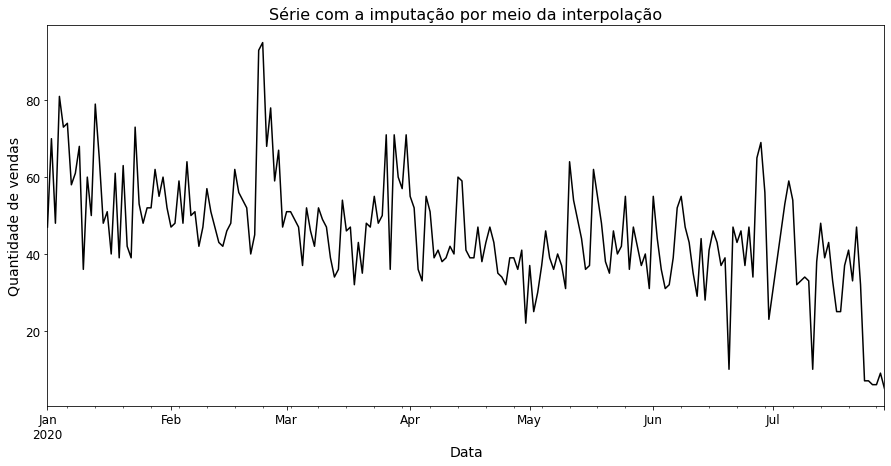

In [9]:
dados1 = dados1.interpolate(method = "linear")

_ = dados1.plot(kind = "line", x = "Lead Created At", y = "indicador_leads", figsize = (15, 7), legend = False, color = "black")
_ = plt.title("Série com a imputação por meio da interpolação", fontsize = 16, color = "black")
_ = plt.xlabel("Data", fontsize = 14, color = "black")
_ = plt.ylabel("Quantidade de vendas", fontsize = 14, color = "black")
_ = plt.tick_params(axis = "x", labelsize = 12, labelcolor = "black")
_ = plt.tick_params(axis = "y", labelsize = 12, labelcolor = "black")

### 3.2. Variável explicativa: Volume diário médio da jornada

In [10]:
dados2 = pd.DataFrame(dados.resample("D", on = "Lead Created At")["tempo_jornada"].mean()).reset_index()

dados2.head()

,Lead Created At,tempo_jornada
0,2020-01-01,29.451766
1,2020-01-02,27.240385
2,2020-01-03,33.897341
3,2020-01-04,27.859436
4,2020-01-05,35.575490


### 3.3. Join entre as primeiras variáveis

In [11]:
of_dados = pd.merge(dados1, dados2, on = ["Lead Created At"])

of_dados.head()

,Lead Created At,indicador_leads,tempo_jornada
0,2020-01-01,47.0,29.451766
1,2020-01-02,70.0,27.240385
2,2020-01-03,48.0,33.897341
3,2020-01-04,81.0,27.859436
4,2020-01-05,73.0,35.575490


### 3.4. Variável explicativa: É feriado?

In [12]:
feriados = holidays.Brazil()

feriados_br = pd.DataFrame({"x": feriados["2020-01-01": "2020-07-31"]})
feriados_br["x"] = pd.to_datetime(feriados_br["x"], format = "%Y-%m-%d")

of_dados = pd.merge(of_dados, feriados_br, how="left", indicator = True, left_on = "Lead Created At", right_on= "x")
of_dados["feriado"] = np.where(of_dados["_merge"] == "both", 1, 0)
of_dados = of_dados.drop(["x", "_merge"], axis = 1)


of_dados.head()

,Lead Created At,indicador_leads,tempo_jornada,feriado
0,2020-01-01,47.0,29.451766,1
1,2020-01-02,70.0,27.240385,0
2,2020-01-03,48.0,33.897341,0
3,2020-01-04,81.0,27.859436,0
4,2020-01-05,73.0,35.575490,0


### 3.5. Variável explicativa: Comuns de séries temporais

In [13]:
import datetime

of_dados["day"] = of_dados["Lead Created At"].apply(lambda t: t.day)
of_dados["weekday"] = of_dados["Lead Created At"].apply(lambda x: x.weekday())

of_dados.head()

,Lead Created At,indicador_leads,tempo_jornada,feriado,day,weekday
0,2020-01-01,47.0,29.451766,1,1,2
1,2020-01-02,70.0,27.240385,0,2,3
2,2020-01-03,48.0,33.897341,0,3,4
3,2020-01-04,81.0,27.859436,0,4,5
4,2020-01-05,73.0,35.575490,0,5,6


### 3.6. Variável explicativa: É fim de semana?

In [14]:
of_dados["is_weekend"] = of_dados["weekday"].apply(lambda x: 1 if x in (5, 6) else 0)

of_dados.head(15)

,Lead Created At,indicador_leads,tempo_jornada,feriado,day,weekday,is_weekend
0,2020-01-01,47.0,29.451766,1,1,2,0
1,2020-01-02,70.0,27.240385,0,2,3,0
2,2020-01-03,48.0,33.897341,0,3,4,0
3,2020-01-04,81.0,27.859436,0,4,5,1
4,2020-01-05,73.0,35.575490,0,5,6,1
5,2020-01-06,74.0,33.169906,0,6,0,0
6,2020-01-07,58.0,30.710322,0,7,1,0
7,2020-01-08,61.0,31.103306,0,8,2,0
8,2020-01-09,68.0,36.669271,0,9,3,0
9,2020-01-10,36.0,36.791209,0,10,4,0


### 3.7. Variável explicativa: Lags

In [15]:
var_lags = list(of_dados.drop(["Lead Created At", "indicador_leads"], axis = 1).columns)

var_lags

['tempo_jornada', 'feriado', 'day', 'weekday', 'is_weekend']

In [16]:
#--- https://medium.com/@rayheberer/generating-lagged-pandas-columns-10397309ccaf (Deus abençoe esse Rapaz)

df_lagged = of_dados[var_lags].copy()
trailing_window_size = 10

for window in range(1, trailing_window_size + 1):
    
    shifted = of_dados[var_lags].shift(window)
    shifted.columns = [x + "_lag" + str(window) for x in of_dados[var_lags].columns]
    
    df_lagged = pd.concat((df_lagged, shifted), axis = 1)
    
df_lagged = df_lagged.dropna().reset_index(drop = True)
df_lagged = df_lagged.drop(columns = var_lags)

df_lagged.head()


#--- Porque isso não deu certo?

# for i in range(4, 10):

#     of_dados[var_lags + f"lag{i}"] = of_dados[var_lags].shift(i)

,tempo_jornada_lag1,feriado_lag1,day_lag1,weekday_lag1,is_weekend_lag1,tempo_jornada_lag2,feriado_lag2,day_lag2,weekday_lag2,is_weekend_lag2,tempo_jornada_lag3,feriado_lag3,day_lag3,weekday_lag3,is_weekend_lag3,tempo_jornada_lag4,feriado_lag4,day_lag4,weekday_lag4,is_weekend_lag4,tempo_jornada_lag5,feriado_lag5,day_lag5,weekday_lag5,is_weekend_lag5,tempo_jornada_lag6,feriado_lag6,day_lag6,weekday_lag6,is_weekend_lag6,tempo_jornada_lag7,feriado_lag7,day_lag7,weekday_lag7,is_weekend_lag7,tempo_jornada_lag8,feriado_lag8,day_lag8,weekday_lag8,is_weekend_lag8,tempo_jornada_lag9,feriado_lag9,day_lag9,weekday_lag9,is_weekend_lag9,tempo_jornada_lag10,feriado_lag10,day_lag10,weekday_lag10,is_weekend_lag10
0,36.791209,0.0,10.0,4.0,0.0,36.669271,0.0,9.0,3.0,0.0,31.103306,0.0,8.0,2.0,0.0,30.710322,0.0,7.0,1.0,0.0,33.169906,0.0,6.0,0.0,0.0,35.575490,0.0,5.0,6.0,1.0,27.859436,0.0,4.0,5.0,1.0,33.897341,0.0,3.0,4.0,0.0,27.240385,0.0,2.0,3.0,0.0,29.451766,1.0,1.0,2.0,0.0
1,33.674134,0.0,11.0,5.0,1.0,36.791209,0.0,10.0,4.0,0.0,36.669271,0.0,9.0,3.0,0.0,31.103306,0.0,8.0,2.0,0.0,30.710322,0.0,7.0,1.0,0.0,33.169906,0.0,6.0,0.0,0.0,35.575490,0.0,5.0,6.0,1.0,27.859436,0.0,4.0,5.0,1.0,33.897341,0.0,3.0,4.0,0.0,27.240385,0.0,2.0,3.0,0.0
2,35.558354,0.0,12.0,6.0,1.0,33.674134,0.0,11.0,5.0,1.0,36.791209,0.0,10.0,4.0,0.0,36.669271,0.0,9.0,3.0,0.0,31.103306,0.0,8.0,2.0,0.0,30.710322,0.0,7.0,1.0,0.0,33.169906,0.0,6.0,0.0,0.0,35.575490,0.0,5.0,6.0,1.0,27.859436,0.0,4.0,5.0,1.0,33.897341,0.0,3.0,4.0,0.0
3,36.030043,0.0,13.0,0.0,0.0,35.558354,0.0,12.0,6.0,1.0,33.674134,0.0,11.0,5.0,1.0,36.791209,0.0,10.0,4.0,0.0,36.669271,0.0,9.0,3.0,0.0,31.103306,0.0,8.0,2.0,0.0,30.710322,0.0,7.0,1.0,0.0,33.169906,0.0,6.0,0.0,0.0,35.575490,0.0,5.0,6.0,1.0,27.859436,0.0,4.0,5.0,1.0
4,35.091618,0.0,14.0,1.0,0.0,36.030043,0.0,13.0,0.0,0.0,35.558354,0.0,12.0,6.0,1.0,33.674134,0.0,11.0,5.0,1.0,36.791209,0.0,10.0,4.0,0.0,36.669271,0.0,9.0,3.0,0.0,31.103306,0.0,8.0,2.0,0.0,30.710322,0.0,7.0,1.0,0.0,33.169906,0.0,6.0,0.0,0.0,35.575490,0.0,5.0,6.0,1.0


In [17]:
df_lagged.shape

(201, 50)

In [18]:
df_lagged.head()

,tempo_jornada_lag1,feriado_lag1,day_lag1,weekday_lag1,is_weekend_lag1,tempo_jornada_lag2,feriado_lag2,day_lag2,weekday_lag2,is_weekend_lag2,tempo_jornada_lag3,feriado_lag3,day_lag3,weekday_lag3,is_weekend_lag3,tempo_jornada_lag4,feriado_lag4,day_lag4,weekday_lag4,is_weekend_lag4,tempo_jornada_lag5,feriado_lag5,day_lag5,weekday_lag5,is_weekend_lag5,tempo_jornada_lag6,feriado_lag6,day_lag6,weekday_lag6,is_weekend_lag6,tempo_jornada_lag7,feriado_lag7,day_lag7,weekday_lag7,is_weekend_lag7,tempo_jornada_lag8,feriado_lag8,day_lag8,weekday_lag8,is_weekend_lag8,tempo_jornada_lag9,feriado_lag9,day_lag9,weekday_lag9,is_weekend_lag9,tempo_jornada_lag10,feriado_lag10,day_lag10,weekday_lag10,is_weekend_lag10
0,36.791209,0.0,10.0,4.0,0.0,36.669271,0.0,9.0,3.0,0.0,31.103306,0.0,8.0,2.0,0.0,30.710322,0.0,7.0,1.0,0.0,33.169906,0.0,6.0,0.0,0.0,35.575490,0.0,5.0,6.0,1.0,27.859436,0.0,4.0,5.0,1.0,33.897341,0.0,3.0,4.0,0.0,27.240385,0.0,2.0,3.0,0.0,29.451766,1.0,1.0,2.0,0.0
1,33.674134,0.0,11.0,5.0,1.0,36.791209,0.0,10.0,4.0,0.0,36.669271,0.0,9.0,3.0,0.0,31.103306,0.0,8.0,2.0,0.0,30.710322,0.0,7.0,1.0,0.0,33.169906,0.0,6.0,0.0,0.0,35.575490,0.0,5.0,6.0,1.0,27.859436,0.0,4.0,5.0,1.0,33.897341,0.0,3.0,4.0,0.0,27.240385,0.0,2.0,3.0,0.0
2,35.558354,0.0,12.0,6.0,1.0,33.674134,0.0,11.0,5.0,1.0,36.791209,0.0,10.0,4.0,0.0,36.669271,0.0,9.0,3.0,0.0,31.103306,0.0,8.0,2.0,0.0,30.710322,0.0,7.0,1.0,0.0,33.169906,0.0,6.0,0.0,0.0,35.575490,0.0,5.0,6.0,1.0,27.859436,0.0,4.0,5.0,1.0,33.897341,0.0,3.0,4.0,0.0
3,36.030043,0.0,13.0,0.0,0.0,35.558354,0.0,12.0,6.0,1.0,33.674134,0.0,11.0,5.0,1.0,36.791209,0.0,10.0,4.0,0.0,36.669271,0.0,9.0,3.0,0.0,31.103306,0.0,8.0,2.0,0.0,30.710322,0.0,7.0,1.0,0.0,33.169906,0.0,6.0,0.0,0.0,35.575490,0.0,5.0,6.0,1.0,27.859436,0.0,4.0,5.0,1.0
4,35.091618,0.0,14.0,1.0,0.0,36.030043,0.0,13.0,0.0,0.0,35.558354,0.0,12.0,6.0,1.0,33.674134,0.0,11.0,5.0,1.0,36.791209,0.0,10.0,4.0,0.0,36.669271,0.0,9.0,3.0,0.0,31.103306,0.0,8.0,2.0,0.0,30.710322,0.0,7.0,1.0,0.0,33.169906,0.0,6.0,0.0,0.0,35.575490,0.0,5.0,6.0,1.0


### 3.8 Adequando a variável resposta para o modelo

In [19]:
y = of_dados.loc[10:, "indicador_leads"]

y.head()

10    60.0
11    50.0
12    79.0
13    65.0
14    48.0
Name: indicador_leads, dtype: float64

## 4. Pipeline

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn import set_config


set_config(display = "diagram")

In [21]:
#--- https://www.kaggle.com/antoinekrajnc/simplest-time-series-using-linear-regression

def TimeSeriesTrainTestSplit(x, y, test_size):
    
        test_index = int(len(x)*(1-test_size))
    
        X_train = x.iloc[:test_index]
        y_train = y.iloc[:test_index]
        X_test = x.iloc[test_index:]
        y_test = y.iloc[test_index:]
        
        return X_train, y_train, X_test, y_test
    
x_treino, y_treino, x_teste, y_teste = TimeSeriesTrainTestSplit(df_lagged, y, 0.2)

In [22]:
stand = StandardScaler()
reg_lin = LinearRegression()
poly = PolynomialFeatures()

model = make_pipeline(stand, poly, reg_lin)
model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [23]:
model.fit(x_treino, y_treino)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [24]:
ts_cross_val = TimeSeriesSplit(n_splits = 5)

cv_ts = cross_val_score(model, x_treino, y_treino, cv = ts_cross_val, scoring = "neg_mean_squared_error")

for x in cv_ts:
     print(x, end = " ")

-650.3321260962759 -218.38631366382975 -283.1097681158891 -466.19133377888954 -510.9030379586134 

In [25]:
model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'polynomialfeatures', 'linearregression', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'polynomialfeatures__degree', 'polynomialfeatures__include_bias', 'polynomialfeatures__interaction_only', 'polynomialfeatures__order', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize'])

In [26]:
params = {}

params["standardscaler"] = [None, StandardScaler(), MinMaxScaler()]
params["polynomialfeatures"] = [None, PolynomialFeatures()]

In [27]:
grid = GridSearchCV(model, params, cv = 5, scoring = "neg_mean_squared_error")

grid.fit(x_treino, y_treino)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'polynomialfeatures': [None, PolynomialFeatures()],
                         'standardscaler': [None, StandardScaler(),
                                            MinMaxScaler()]},
             scoring='neg_mean_squared_error')

In [28]:
results = pd.DataFrame(grid.cv_results_)

results.sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_polynomialfeatures,param_standardscaler,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.007516,0.001018,0.002867,0.000141,None,MinMaxScaler(),"{'polynomialfeatures': None, 'standardscaler':...",-145.506039,-365.973588,-121.608234,-376.607505,-124.743065,-226.887686,118.238041,1
0,0.012415,0.003148,0.005745,0.001699,None,None,"{'polynomialfeatures': None, 'standardscaler':...",-146.011479,-366.114794,-121.610470,-376.607505,-124.795990,-227.028048,118.192285,2
1,0.010792,0.003119,0.004821,0.002973,None,StandardScaler(),"{'polynomialfeatures': None, 'standardscaler':...",-145.841459,-366.485695,-121.703723,-376.559081,-124.786006,-227.075193,118.275834,3
4,0.042181,0.000610,0.005676,0.000153,PolynomialFeatures(),StandardScaler(),"{'polynomialfeatures': PolynomialFeatures(), '...",-905.808007,-1629.743249,-208.046985,-525.453925,-508.026153,-755.415664,490.053676,4
5,0.043887,0.003034,0.005435,0.000210,PolynomialFeatures(),MinMaxScaler(),"{'polynomialfeatures': PolynomialFeatures(), '...",-1013.245660,-2952.195369,-354.710925,-860.953913,-985.172017,-1233.255577,891.644891,5
3,0.038918,0.001848,0.005382,0.000177,PolynomialFeatures(),None,"{'polynomialfeatures': PolynomialFeatures(), '...",-2358.739701,-13248.783162,-433.525934,-1234.646094,-1143.427641,-3683.824507,4822.049684,6


In [ ]:
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
x = sc_x.fit_transform(df_lagged)
x = pd.DataFrame(x)

x.head()

In [ ]:
from sklearn.linear_model import LinearRegression

reg_lin = LinearRegression()

reg_lin.fit(x_treino, y_treino)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

ts_cross_val = TimeSeriesSplit(n_splits = 5)

cv_ts = cross_val_score(reg_lin, x_treino, y_treino, cv = ts_cross_val, scoring = "neg_mean_squared_error")
cv_ts

In [ ]:
y_pred = reg_lin.predict(x_teste)

y_pred[:6]

In [ ]:
y_teste.head()

In [ ]:
_ = plt.figure(figsize = (15, 7))
_ = plt.plot(y_teste.values, "blue", label = "Valor real", linewidth = 2)
_ = plt.plot(y_pred, "green", label = "Predição", linewidth = 2)
_ = plt.legend(loc = "best")

# Próxima missão:

- Tratar outlier 

---

## Testes

In [ ]:
# x = of_dados.dropna().drop(["Lead Created At", "indicador_leads", "tempo_jornada", "feriado", "day", "weekday", "is_weekend"], 
#                             axis = 1).reset_index(drop = True)
    
# x.shape

In [ ]:
# y = of_dados.dropna()["indicador_leads"]

# y.shape

In [ ]:
# from sklearn.preprocessing import StandardScaler

# sc_x = StandardScaler()
# x = sc_x.fit_transform(x)
# x = pd.DataFrame(x)

In [ ]:
# #--- https://www.kaggle.com/antoinekrajnc/simplest-time-series-using-linear-regression

# def TimeSeriesTrainTestSplit(x, y, test_size):
    
#         test_index = int(len(x)*(1-test_size))
    
#         X_train = x.iloc[:test_index]
#         y_train = y.iloc[:test_index]
#         X_test = x.iloc[test_index:]
#         y_test = y.iloc[test_index:]
        
#         return X_train, y_train, X_test, y_test
    
# x_treino, y_treino, x_teste, y_teste = TimeSeriesTrainTestSplit(x, y, 0.2)

In [ ]:
# from sklearn.linear_model import LinearRegression

# reg_lin = LinearRegression()

# reg_lin.fit(x_treino, y_treino)

In [ ]:
# from sklearn.model_selection import TimeSeriesSplit
# from sklearn.model_selection import cross_val_score

# ts_cross_val = TimeSeriesSplit(n_splits = 5)

# cv_ts = cross_val_score(reg_lin, x_treino, y_treino, cv = ts_cross_val, scoring = "neg_mean_squared_error")
# cv_ts

In [ ]:
# y_pred = reg_lin.predict(x_teste)

# y_pred

In [ ]:
# _ = plt.figure(figsize = (15, 7))
# _ = plt.plot(y_teste.values, "blue", label = "Valor real", linewidth = 2)
# _ = plt.plot(y_pred, "green", label = "Predição", linewidth = 2)
# _ = plt.legend(loc = "best")

In [ ]:
# plt.figure(figsize=(20,8))
# plt.plot(regressor.predict(X_test[-400:]), "y", label="prediction", linewidth=2.0)
# plt.plot(y_test.values[-400:], "g", label="real_values", linewidth=2.0)
# plt.legend(loc="best")